# Deep calibration of the stochastic local Heston Model

Here we investigate the calibration of the stochastic local volatility (SLV) Heston model by means of deep neural networks. The considered model is
\begin{equation}
\begin{cases}
d S_t = \big( r - d \big) S_t dt + \sqrt{\nu_t} L(t, S_t) dW_t^S \\
d\nu_t = \kappa \big( \theta - \nu_t \big) dt + \sigma \sqrt{\nu_t} dW_t^\nu \\
dW_t^S  dW_t^\nu = \rho dt \,.
\end{cases}
\end{equation}
with initial value $ S_0 $. $r,d$ are the risk-free interest and dividend rate. The stochastic part of the model is given by a Heston model with parameters $\kappa,\theta,\sigma,\rho$ describing the mean reversion speed, the long time variance, the vol of vol and the correlation between the Wiener processes $dW_t^S, dW_t^\nu$, respectively. The function $L$ is called \textit{leverage function} and represents the local part of the SLV model. In this first part of the calibration we always assume $L=1$, i.e. we consider the pure Heston model with parameters $\kappa,\theta,\sigma,\rho$ which we want to calibrate to observable market data of European call options by learning the pricing map from model parameters to implied volatility surface directly by means of a neural network. The second part of the calibration is contained in the second notebook heston_incl_locvol_LVPart, which aims at learning the leverage function from the market data by an additional neural network.

This notebook considers the first part, i.e. learning the mapping from Heston-model parameters to implied volatility surfaces by a deep neural network, which subsequently is employed as an fast and efficient calibration tool. The notebook is, with some minor changes, taken from (https://nbviewer.jupyter.org/url/people.math.ethz.ch/~jteichma/lecture_ml_web/heston_calibration.ipynb) from Cuchiero, Teichmann et al (https://people.math.ethz.ch/~jteichma/index.php?content=teach_mlf2019).

In the work of Andres Hernandez's [Model calibration with neural networks](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2812140), or work of Cuchiero et al., one directly learns the mapping from volatility/price data to model parameters
$$
\text{data} \mapsto (\kappa,\theta,\sigma,\rho) \,.
$$
This is, however, generally an ill-posed inverse problem. Instead of this, the notebook here follows a less ambitious, but mathematically better justifiable approach to learn the mapping
$$
(\kappa,\theta,\sigma,\rho) \mapsto \text{data} 
$$
via a neural network. This mapping is often quite regular and is discussed in more detail and generality by Horvath et al. in [Deep learning volatility](https://arxiv.org/abs/1901.09647). After training, this map can be used for efficiently calibrating the Heston model to observable market data.

In [1]:
# Import packages
from __future__ import division
import time
import pandas as pd
import numpy as np
import datetime as dt
import math

import QuantLib as ql
# This controls whether functionEvaluation is available in QuantLib library
has_function_evals = True
float_type = np.float32

from itertools import product
import matplotlib.pyplot as plt
import pickle
import os
data_dir = os.getcwd()

from os.path import isfile
from os import getcwd
from copy import deepcopy, copy
from six import string_types
import dill
from functools import partial


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


import tensorflow as tf
import tensorflow_probability as tfp

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Input
from keras.layers.merge import add
#from keras.regularizers import l2
from keras.layers.advanced_activations import ELU
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, \
                            Callback, TensorBoard

from keras import backend as K
from keras.constraints import maxnorm
#from keras import initializations
from keras.initializers import VarianceScaling, RandomUniform
#from keras.utils import Sequence
from keras.utils.vis_utils import plot_model

from scipy.optimize import differential_evolution, minimize, dual_annealing, basinhopping
from scipy.stats import norm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Calendar conventions
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
# Option conventions
# moneyness = [.8, .85, .9, .95, .975, .99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.15, 1.2] # S_0/K 
# delta_times = [15, 30, 45, 60, 90, 120, 180, 240, 300, 360, 420]

moneyness = [.8, .85, .9, .95, .98, .99, 1.0, 1.01, 1.02, 1.05, 1.1, 1.15, 1.2] # S_0/K 
# delta_times = [5, 10, 15, 20, 30, 40, 60, 120, 180, 300, 420]
delta_times = [15, 30, 45, 60, 90, 120, 180, 240, 300, 360, 420]

moneyness2 = [.8, .85, .9, .95, .98, .99, 1.0, 1.01, 1.02, 1.05, 1.1, 1.15, 1.2]
moneyness2.reverse()

moneyness_dense = [.8 + .01*k for k in range(-1,int((1.2 - .8)*100) + 2 + 1)] # S_0/K 
moneyness_dense.reverse()
delta_times_dense = [15 + 5*k for k in range(-1,int((420-15)/5) + 1 + 1)]



# moneyness = [.99, 1.0, 1.01] # S_0/K 
# delta_times = [15, 30, 45]


'''
Dictionary defining model
It requires 3 parameters:
    -name
    -process
    -model: a function that creates a model. It takes as parameter a 
            yield curve handle
    -engine: a function that creates an engine. It takes as paramters a
            calibration model and a yield curve handle
    -option_type            
Optional parameters:
    -transformation: a preprocessing function
    -inverse_transformation: a postprocessing function
'''
he_analytic = {'name' : 'Heston',
               'process' : ql.HestonProcess,
               'model' : ql.HestonModel, 
               'engine' : ql.AnalyticHestonEngine,
               'option_type' : ql.Option.Call,
               'transformation' : np.log, 
               'inverse_transformation' : np.exp}


# Helper functions
def create_imp_vol_skeleton(strike_struct, expiration_dates_struct, 
                            calculation_date, spot_price):
    '''
    Create the structure (skeleton) on which it is possible to price all options.
    '''
    strikes = [spot_price/m for m in strike_struct]
    expiries = [calculation_date+d_time for d_time in expiration_dates_struct]
    ttm_days = [(d-calculation_date) for d in expiries] # time to maturity
    ttm_year = [day_count.yearFraction(calculation_date, d) for d in expiries]
    
    new_array = np.array((ttm_days,strikes))
    cartesian_product_vola_surface = list(product(*new_array))
    df = pd.DataFrame(cartesian_product_vola_surface, 
                        columns=['ttm','strikes'])
    return strikes, np.array((ttm_year)), expiries, df

def set_risk_free_rate(calculation_date, risk_free_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,risk_free_rate,day_count))

def set_dividend_rate(calculation_date, dividend_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,dividend_rate,day_count))

def set_spot(spot_price):
    return ql.QuoteHandle(ql.SimpleQuote(spot_price))

def create_european_option(calculation_date, opt_type, strike_price, ttm):
    # Create European options
    payoff = ql.PlainVanillaPayoff(opt_type, strike_price)
    maturity = calculation_date+int(ttm)
    exercise = ql.EuropeanExercise(maturity)
    return ql.VanillaOption(payoff, exercise)


class Heston_Model:
    def __init__(self, model_dict, spot_price=100., risk_free_rate=0.01, dividend_rate=0.0,
                 inst_var=0.1, calculation_date=ql.Date(8,11,2015),  
                 expiration_dates_struct=delta_times, strike_struct=moneyness,
                 mean_rev_speed=None, eq_var=None, vol_of_vol=None, correlation=None):
        '''
        This class implements the Heston model for a series of given parameters.
        The output will be a dataframe where the columns are parameters, strikes
        time_to_maturities, prices and values of the volatility surface.
        '''
        self._model_dict = model_dict
        if ('process' not in self._model_dict 
            or 'model' not in self._model_dict
            or 'engine' not in self._model_dict
            or 'name' not in self._model_dict
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        
        self.option_type = self._model_dict['option_type']
        self.calculation_date = calculation_date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        #heston model parameters
        self.nb_params = 4
        self.sigma = vol_of_vol
        self.rho = correlation
        self.theta = eq_var
        self.kappa = mean_rev_speed
        self.heston_param = np.array((self.kappa,self.theta,self.sigma,self.rho))
        
        # volatility surface structure
        self.strikes, self.ttm, self.expiries, self.df = create_imp_vol_skeleton(
                                    strike_struct, expiration_dates_struct, 
                                    calculation_date, spot_price)
        
        # Yield curve, dividends, spot and instantaneous volatility
        self.risk_free_rate = risk_free_rate
        self.dividend_rate = dividend_rate
        self.spot_price = spot_price
        self.v0 = inst_var
        
        self.ircurve = set_risk_free_rate(self.calculation_date, self.risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, self.dividend_rate)
        self.spot = set_spot(self.spot_price)
        
        process = self.__create_process(self.kappa,self.theta,self.sigma,self.rho)
        model = self._model_dict['model'](process)
        engine = self._model_dict['engine'](model)
        
        eu_options = [create_european_option(self.calculation_date,self.option_type,s,t) 
                   for s,t in zip(self.df['strikes'], self.df['ttm'])]
        [opt.setPricingEngine(engine) for opt in eu_options]
        self.df['price'] = [o.NPV() for o in eu_options]
#        self.df['analytical_price'] = self.df['price'][:] #####

    def __create_process(self,kappa,theta,sigma,rho):
        # Creation of the object Process
        return self._model_dict['process'](self.ircurve,self.dividend,self.spot,
                self.v0,kappa,theta,sigma,rho)
    
# Helper functions for the class HestonGroup
def datetime_to_ql(d):
    return ql.Date(d.day,d.month,d.year)



def ql_to_datetime(dateql):
    return dt.datetime(dateql.year(), dateql.month(), dateql.dayOfMonth())

def ql_to_datetime_settings_dict(dates_ql, dictionary):
    if bool(dictionary):
        for dateql in dates_ql:
            helper = ql_to_datetime(dateql)
            dictionary[helper]=dictionary.pop(dateql)                                                                
                
def datetime_to_ql_settings_dict(dates, dictionary):
    if bool(dictionary):
        dates = sorted(dates)
        for date in dates:
            helper = date_to_ql(date)
            dictionary[helper] = dictionary.pop(date)
            
def save_dictionary(dictionary, name_dict, path=data_dir):
        filehandler = open(path+ '/' +name_dict+'.pkl','wb')
        pickle.dump(dictionary,filehandler)
        filehandler.close()

def load_dictionary(name_dict, path=data_dir):
        with open(path+ '/' +name_dict+'.pkl', 'rb') as handle:
            dictionary = pickle.load(handle)
        return dictionary
    
# Bounds for the calibration of the parameters (in implied_vola_generation.py)
he_generation_bounds = [(0.5,10.), (0.05,0.8), (0.05,0.8), (-0.99,0.99)] #kappa,theta,sigma,rho
he_calibration_bounds = [(0.001,15.), (0.001,6.), (0.005,4.), (-0.999,0.999)]
he_mean_as_initial_point = [5., 1.5, 1., 0.]

# Function to plot the volatility surface
def plot_surface(Z, z_label, main_title, string1='', string2='', W=None, string3='', **kwargs):
    times = kwargs.get('delta_times', delta_times)
    money = kwargs.get('moneyness', moneyness)
    X = times; Y = money
    X, Y = np.meshgrid(X, Y)
    X = np.transpose(X); Y = np.transpose(Y)
    if Z.shape != (X.shape[0],Y.shape[1]):
        Z = Z.reshape((len(times),len(money)))
    if W is not None and W.shape != (X.shape[0],Y.shape[1]):
        W = W.reshape((len(times),len(money)))
    
    if W is None:
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        fig.suptitle(main_title)
        plt.show()
    else:
# COMMENT IF MAYAVI NOT AVAILABLE
#        from mayavi import mlab
#        fig = mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,600))
#        ax_ranges = [min(times), max(times), min(money), max(money), 0, max(np.amax(Z),np.amax(W))]
#        surf3 = mlab.surf(X, Y, Z, colormap='Oranges', warp_scale='auto')
#        surf4 = mlab.surf(X, Y, W, colormap='Blues', warp_scale='auto')
#        cb1 = mlab.colorbar(object=surf3, title='Original IVS', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#Original
#        cb2 = mlab.colorbar(object=surf4, title='Neural net 1', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#NN1
#        cb1.scalar_bar_representation.position = [0.12, 0.15] #bottom left
#        cb1.scalar_bar_representation.position2 = [0.1, 0.8] # from position!!!
#        cb2.scalar_bar_representation.position = [0.01, 0.15] #bottom left
#        cb2.scalar_bar_representation.position2 = [0.1, 0.8]
##        mlab.view(60, 74, 17, [-2.5, -4.6, -0.3])
#        ax = mlab.axes(surf3, color=(.7, .7, .7), #extent=ax_extent,
#                       ranges=ax_ranges, xlabel='time to maturity (days)', 
#                       ylabel='moneyness (%)', zlabel=z_label, nb_labels=5)
#        ax.axes.font_factor=0.8
#        title = mlab.title(main_title)
#        title.x_position = 0.3
#        title.y_position = 0.8
#        title.width = 0.5
#        print(title.__dict__)
#        mlab.show()
# UNCOMMENT IF MAYAVI NOT AVAILABLE        
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.Oranges, linewidth=0, antialiased=True, alpha=0.2)
        surf2 = ax.plot_surface(X, Y, W, cmap=cm.Blues, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        fig.colorbar(surf2, shrink=0.6, aspect=20, ax=ax)
        ax.text2D(0.15, 0.96, string3, transform=ax.transAxes)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        fig.suptitle(main_title)
        plt.show()
    return fig
        
        
'''
 - Search for the implied volatility - 
Since the differential evolution algorithm is extremly long, I have to use
another method to derive the implied volatility for option prices.
References are Li and Lee (2011) and Stefanica and Radoicic (2017).
'''

def approx_func(x):
    return 0.5 + 0.5*np.sign(x)*np.sqrt(1. - np.exp(-2.*(x**2)/np.pi))

def guess_StefanicaRadoicic(option_type, strike, option_price, spot_price,
                            ir_discount, dr_discount):
    
    forward = spot_price * dr_discount / ir_discount
    ey = forward/strike #ey=exp(y)
    emy = strike/forward #emy=exp(-y)
    y = np.log(ey) #(simple) log moneyness
    alpha = option_price/(strike*ir_discount)
    
    if option_type==1:
        #Call
        R = 2.*alpha - ey + 1.
    else:
        #Put
        R = 2.*alpha + ey - 1.
    pi_term = 2./np.pi
    arg_exp_term = (1.-pi_term)*y
    R2 = R**2
    
    a = np.exp(arg_exp_term)
    A = (a - 1./a)**2
    b = np.exp(pi_term*y)
    B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
    C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
    beta = 2.*C / (B + np.sqrt(B**2 + 4.*A*C))
    gamma = - np.pi/2.*np.log(beta)    
    
    if y>=0.:
        if option_type==1: #call
            O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
        else:
            O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
        if option_price <= O0:
            nu = np.sqrt(gamma+y) - np.sqrt(gamma-y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    else:
        if option_type==1: #call
            O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
        else:
            O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
        if option_price <= O0:
            nu = np.sqrt(gamma-y) - np.sqrt(gamma+y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    return nu

# @tf.function
# def guess_StefanicaRadoicic_tf(option_type, strike, option_price, spot_price,
#                             ir_discount, dr_discount):
    
#     forward = spot_price * dr_discount / ir_discount
#     ey = forward/strike #ey=exp(y)
#     emy = strike/forward #emy=exp(-y)
#     y = np.log(ey) #(simple) log moneyness
#     alpha = option_price/(strike*ir_discount)
    
#     if option_type==1:
#         #Call
#         R = 2.*alpha - ey + 1.
#     else:
#         #Put
#         R = 2.*alpha + ey - 1.
#     pi_term = 2./np.pi
#     arg_exp_term = (1.-pi_term)*y
#     R2 = R**2
    
#     a = np.exp(arg_exp_term)
#     A = (a - 1./a)**2
#     b = np.exp(pi_term*y)
#     B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
#     C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
#     # use in connection with tensorflow
#     beta = 2.*C / (B + tf.sqrt(B**2 + 4.*A*C))
#     gamma = - np.pi/2.*tf.log(beta)    
    
    
#     if y>=0.:
#         if option_type==1: #call
#             O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
#         else:
#             O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
#         if option_price <= O0:
#             nu = tf.sqrt(gamma+y) - tf.sqrt(gamma-y)
#         else:
#             nu = tf.sqrt(gamma+y) + tf.sqrt(gamma-y)
#     else:
#         if option_type==1: #call
#             O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
#         else:
#             O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
#         if option_price <= O0:
#             nu = tf.sqrt(gamma-y) - tf.sqrt(gamma+y)
#         else:
#             nu = tf.sqrt(gamma+y) + tf.sqrt(gamma-y)
#     return nu

def Phi(x,nu):
    nu2 = nu**2
    abs_term = 2.*np.abs(x)
    return (nu2-abs_term)/(nu2+abs_term)
def N_plus(x,nu):
    return norm.cdf(x/nu + 0.5*nu)
def N_minus(x,nu):
    return np.exp(-x)*norm.cdf(x/nu - 0.5*nu)
def F(nu, x, c_star, omega):
    return c_star + N_minus(x,nu) + omega*N_plus(x,nu)
def G(nu, x, c_star, omega):
    argument = F(nu, x, c_star, omega)/(1.+omega)
    term = norm.ppf(argument)
    return term + np.sqrt(term**2 + 2.*np.abs(x))




# normal_tf = tfp.distributions.Normal(loc=0., scale=1.)

# @tf.function
# def Phi_tf(x,nu):
#     nu2 = nu**2
#     abs_term = 2.*abs(x)
#     return (nu2-abs_term)/(nu2+abs_term)

# @tf.function
# def N_plus_tf(x,nu):
#     return normal_tf.cdf(x/nu + 0.5*nu)

# @tf.function
# def N_minus_tf(x,nu):
#     return np.exp(-x)*normal_tf.cdf(x/nu - 0.5*nu)

# @tf.function
# def F_tf(nu, x, c_star, omega):
#     return c_star + N_minus_tf(x,nu) + omega*N_plus_tf(x,nu)
 
# @tf.function
# def G_tf(nu, x, c_star, omega):
#     argument = F_tf(nu, x, c_star, omega)/(1.+omega)
#     term = norm.ppf(argument)
#     return term + np.sqrt(term**2 + 2.*np.abs(x))
    
def SOR_TS(option_type, strike, discount_ir, discount_dr, option_price, 
                     spot_price, guess, omega, accuracy, max_iterations=20):
    
    # assert (option_price >= 0.),'Price must be positive.'
    
    forward = spot_price * discount_dr / discount_ir
    x = np.log(forward/strike) #(simple) log moneyness
    
    if option_type==1:  #call
        c = option_price/(spot_price*discount_dr)
    else:   #put
        c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
    if x > 0.:
        # formula in-out duality
        c = c*forward/strike + 1. - forward/strike
        assert (c >= 0.),'Normalized price must be positive.'
        x = -x
    
    if not guess:
        guess = guess_StefanicaRadoicic(option_type, strike, option_price, 
                                       spot_price, discount_ir, discount_dr)
    assert (guess >= 0.),'Initial guess must be positive.'
    
    nIter = 0
    nu_k = nu_kp1 = guess
    difference = 1.
    while (np.abs(difference)>accuracy and nIter<max_iterations):
        nu_k = nu_kp1
        alpha_k = (1.+omega)/(1.+Phi(x,nu_k))
        nu_kp1 = alpha_k*G(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
        difference = nu_kp1 - nu_k
        nIter +=1
    return nu_kp1



# @tf.function
# def SOR_TS_tf(option_type, strike, discount_ir, discount_dr, option_price, 
#                      spot_price, guess, omega, accuracy, max_iterations=20):
    
#     # assert (option_price >= 0.),'Price must be positive.'
    
#     forward = spot_price * discount_dr / discount_ir
#     x = np.log(forward/strike) #(simple) log moneyness
    
#     if option_type==1:  #call
#         c = option_price/(spot_price*discount_dr)
#     else:   #put
#         c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
#     if x > 0.:
#         # formula in-out duality
#         c = c*forward/strike + 1. - forward/strike
#         assert (c >= 0.),'Normalized price must be positive.'
#         x = -x
    
#     if not guess:
#         guess = guess_StefanicaRadoicic_tf(option_type, strike, option_price, 
#                                        spot_price, discount_ir, discount_dr)
#     assert (guess >= 0.),'Initial guess must be positive.'
    
#     nIter = 0
#     nu_kp1 = guess
#     # nu_k = nu_kp1 = guess
#     # difference = 1.
#     while (nIter<max_iterations):
#     # while (np.abs(difference)>accuracy and nIter<max_iterations):
#         nu_k = nu_kp1
#         alpha_k = (1.+omega)/(1.+Phi_tf(x,nu_k))
#         nu_kp1 = alpha_k*G_tf(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
#         # difference = nu_kp1 - nu_k
#         nIter = nIter + 1
#     return nu_kp1


def return_year_fraction(date, ttm):
    return [day_count.yearFraction(date,date+int(nd)) for nd in ttm]

class VolaSurface:
    '''
    This class takes in input some prices and transform them in a volatility surface.
    '''
    def __init__(self, option_type, spot_price=100, risk_free_rate=0.01, dividend_rate=0.0,
                 calculation_date=ql.Date(8,11,2015), df=None):   
        # Main data structure
        self.data = df

        # Check to see if there are the correct columns        
        if not 'ttm' in self.data.columns \
        or not 'strikes' in self.data.columns \
        or not 'price' in self.data.columns:
            raise RuntimeError('Some necessary data is missing')
        
        # Option type, calculation date
        self.option_type = option_type
        self.calculation_date = calculation_date #already a ql Date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        # Yield curve, dividends, spot
        self.ircurve = set_risk_free_rate(self.calculation_date, risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, dividend_rate)
        self.spot = set_spot(spot_price)
        
        # Tolerance on implied volatility error
        self.tol = 1.e-14
    

    def __implied_vola(self, price, strike, ttm):
        # Find the implied volatility through other algorithms
        discount_ir = self.ircurve.discount(self.calculation_date+int(ttm))
        discount_dr = self.dividend.discount(self.calculation_date+int(ttm))
        sol = 0.0
        try:
            sol = SOR_TS(self.option_type, strike, discount_ir, discount_dr,
                         price, self.spot.value(), guess=None, 
                         omega=1., accuracy=self.tol)
        except (RuntimeWarning, AssertionError) as e:
            print(repr(e))
        yearly_ttm = day_count.yearFraction(self.calculation_date, self.calculation_date+int(ttm))
        sol = sol/np.sqrt(yearly_ttm)
        return sol
        
        
    def get_implied_vola(self):
        ivs = []
        for i in range(len(self.data['price'])):
            ivs.append(self.__implied_vola(self.data['price'][i],
                                           self.data['strikes'][i],
                                           self.data['ttm'][i]) + 1.E-5) #regularization
            if ivs[i]==0.:
                raise ValueError('Zero implied volatility!')
        return ivs
    
    
class HestonGroup:
    
    def __init__(self, model_dict=he_analytic, first_date=ql.Date(1,1,2018), 
                 end_date=ql.Date(2,1,2018)):
        #Create a collection of object of type Heston_Model
        self._model_dict = model_dict
        if ('model' not in self._model_dict
            or 'process' not in self._model_dict
            or 'engine' not in self._model_dict 
            or 'name' not in self._model_dict 
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        self.model_name = self._model_dict['name'].replace("/", "").lower()
        
        # Option type
        self.option_type = self._model_dict['option_type']
        # Dates
        self.dates = pd.date_range(ql_to_datetime(first_date), ql_to_datetime(end_date))
        #print(self.dates)
        # in this way I generate a date for every day (with holidays)
        self.dates_ql = [datetime_to_ql(d) for d in self.dates]
        #print(self.dates_ql)
        
        # Dictionaries
        self.he_observable = {} #contains s0, ir, dr and v0
        self.he_hist_parameters = {} #contains s0, ir, dr + 5 heston params
        self.he_hist_df = {} #contains the entire data_frame with ttm, strikes, prices
        self.he_hist_iv = {} #contains the implied vola surface given by the data_frame
        
        
    # Methods for the generation of the fake volatility surfaces
    def __generate_ir(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.08)
    def __generate_dr(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.03)
    def __generate_sp(self):
        return 100*(np.random.beta(a=8, b=8) + 1.0E-2)
    def __generate_theta(self):
        return np.random.uniform(low=he_generation_bounds[1][0], high=he_generation_bounds[1][1])
    def __generate_v0(self):
        return np.random.uniform(low=0.001, high=0.9)**2
    def __generate_rho(self):
        return np.random.uniform(low=he_generation_bounds[3][0], high=he_generation_bounds[3][1])
    def __generate_kappa(self):
        return np.random.uniform(low=he_generation_bounds[0][0], high=he_generation_bounds[0][1])
    def __generate_sigma(self):
        return np.random.uniform(low=he_generation_bounds[2][0], high=he_generation_bounds[2][1])

    def create_Heston_model(self, date, **kwargs):
        '''
        Use fake (random) datas to create the data structure for the Heston model
        and the volatility surface.
        '''
        ir = kwargs.get('ir', self.__generate_ir())
        dr = kwargs.get('dr', self.__generate_dr())
        sp = kwargs.get('sp', self.__generate_sp())
        v0 = kwargs.get('v0', self.__generate_v0())
        rho = kwargs.get('rho', self.__generate_rho())
        sigma = kwargs.get('sigma', self.__generate_sigma()) #vol of vol! Not implied vola!
        # Loop until the Feller condition is satisfied
        theta = kwargs.get('theta', self.__generate_theta())
        kappa = kwargs.get('kappa', self.__generate_kappa())
        while 2*kappa*theta <= sigma**2:
            theta = self.__generate_theta()
            kappa = self.__generate_kappa()
        
        return Heston_Model(model_dict=he_analytic, spot_price=sp, risk_free_rate=ir,
                            dividend_rate=dr, calculation_date=date, 
                            expiration_dates_struct=delta_times, 
                            strike_struct=moneyness, vol_of_vol=sigma, 
                            correlation=rho, eq_var=theta, inst_var=v0, 
                            mean_rev_speed=kappa)
    
    
    def show_ivs(self, **kwargs):
        '''
        Plot implied volatility surface
        '''
        rd = self.dates_ql[0]
        hest_obj = self.create_Heston_model(date = rd, **kwargs)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=1,theta=0.06,sigma=0.4)
#        https://hpcquantlib.wordpress.com/2016/09/11/the-collocating-local-volatility-model/
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=1,rho=-0.9,kappa=5.7,theta=1,sigma=0.1)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.5**2,rho=0.5,kappa=6.2,theta=0.4**2,sigma=0.8)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.4**2,rho=-0.1,kappa=1.5,theta=0.9**2,sigma=0.8)
        obs_str = ['S0 =', 'ir =', 'dr =', 'v0 =']
        obs = [hest_obj.spot_price, hest_obj.risk_free_rate,
               hest_obj.dividend_rate, hest_obj.v0]
        obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]
        params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
        params = [hest_obj.kappa,hest_obj.theta, hest_obj.sigma, hest_obj.rho]
        params_str = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, params)]
        df = hest_obj.df
        ivs = VolaSurface(option_type=hest_obj.option_type, 
                          spot_price=hest_obj.spot_price, 
                          risk_free_rate=hest_obj.risk_free_rate, 
                          dividend_rate=hest_obj.dividend_rate,
                          calculation_date=hest_obj.calculation_date, 
                          df=hest_obj.df).get_implied_vola()
        plot_surface(Z=np.array(ivs), z_label='ivs', 
                     main_title='Heston Imp Vola Surface',
                     string1=', '.join(o for o in obs_str), 
                     string2=', '.join(p for p in params_str))
#         return np.array(ivs), df
    
    
    def create_historical_process_data(self, **kwargs):
        '''
        Real creation of Heston data: big loop over all dates.
        '''
        k = 0
        while k<len(self.dates_ql):
            datehelper = self.dates_ql[k]
            try:
                print('Date: ',datehelper)
                hest_obj = self.create_Heston_model(datehelper)
                self.he_observable[datehelper] = np.array((hest_obj.spot_price,hest_obj.risk_free_rate,
                               hest_obj.dividend_rate,hest_obj.v0))
                self.he_hist_parameters[datehelper] = np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho))
                print('Parameters: ',np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho)))
                self.he_hist_df[datehelper] = hest_obj.df
                ivs = VolaSurface(option_type=hest_obj.option_type, 
                                  spot_price=hest_obj.spot_price, 
                                  risk_free_rate=hest_obj.risk_free_rate, 
                                  dividend_rate=hest_obj.dividend_rate,
                                  calculation_date=hest_obj.calculation_date, 
                                  df=hest_obj.df)
                self.he_hist_iv[datehelper] = ivs.get_implied_vola()
            except (ValueError) as e:    
                print(e)
            else:
                k += 1
        
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving historical data')
            #for date in self.he_observable.keys():
            #    self.he_observable[ql_to_datetime(date)]=self.he_observable.pop(date)
            #    print(ql_to_datetime(date))
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_observable)
            #print('x')
            save_dictionary(dictionary=self.he_observable, name_dict='he_observable')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_parameters)
            save_dictionary(dictionary=self.he_hist_parameters, name_dict='he_hist_parameters')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_df)
            save_dictionary(dictionary=self.he_hist_df, name_dict='he_hist_df')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_iv)
            save_dictionary(dictionary=self.he_hist_iv, name_dict='he_hist_iv')

    
    def training_data_param_to_iv(self, nb_samples, **kwargs):
        '''
        Fake creation of Heston data for TRAINING OF NN1: from parameters to
        implied volatility surfaces.
        '''
        # Set seed
        seed = kwargs.get('seed',0)
        print('Seed: %s'%seed)
        np.random.seed(seed)
        print('NN1-training data are produced')
        
        # Empty structures
        x = []
        y = []
        
        fake_date = self.dates_ql[0]
        ql.Settings.instance().evaluationDate = fake_date
        i = 0
        while i<nb_samples:
            try:
                hest_obj = None
                hest_obj = self.create_Heston_model(fake_date)
                imp_vola_obj = VolaSurface(option_type=hest_obj.option_type, 
                                               spot_price=hest_obj.spot_price, 
                                               risk_free_rate=hest_obj.risk_free_rate, 
                                               dividend_rate=hest_obj.dividend_rate,
                                               calculation_date=hest_obj.calculation_date, 
                                               df=hest_obj.df)
                ivs = imp_vola_obj.get_implied_vola()
            except ValueError as e:
                print(hest_obj.heston_param)
                print('Error: %s, sample %s'%(e,i+1)); print(' ')
            else:
                x.append([hest_obj.spot_price, hest_obj.risk_free_rate, hest_obj.dividend_rate,
                          hest_obj.v0,hest_obj.kappa,hest_obj.theta,hest_obj.sigma,hest_obj.rho])
                y.append(ivs)
                i += 1
                
        # There is no need to clean data afterwards in this way
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            print('file name %s'%(self.model_name+'_'+kwargs['file_name']))
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving data for training of NN1')
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_inputNN1', x) #name: Heston_train_he_inputNN
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_outputNN1', y)
#         return (x,y)

In the sequel one example of a volatility surface is drawn ...

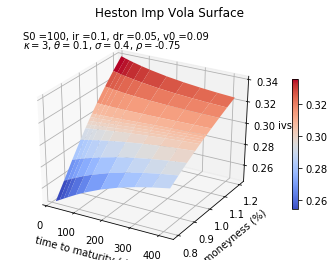

In [3]:
# Plot example of volatility surface
# he_group.show_ivs()
he_group = HestonGroup(first_date=ql.Date(1,1,2018), end_date=ql.Date(1,1,2018))

he_group.show_ivs(sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=3,theta=0.1,sigma=0.4)

Now some data with random parameters are created in order to look whether the presented methodology is able to reproduce the parameters from the volatility surface.

In [4]:
'''
Create historical data
'''

start_date = dt.datetime(2017,1,1)
end_date = dt.datetime(2017,1,5)

f_date = datetime_to_ql(start_date)
e_date = datetime_to_ql(end_date)
heston_processes = HestonGroup(first_date=f_date, end_date=e_date)
heston_processes.create_historical_process_data(save=True, seed=1)

Date:  January 1st, 2017
Parameters:  [ 6.93780163  0.64173482  0.43601414 -0.42250136]
Date:  January 2nd, 2017
Parameters:  [7.66706446 0.78867634 0.68887382 0.57716397]
Date:  January 3rd, 2017
Parameters:  [1.13134531 0.42116752 0.69745504 0.54346288]
Date:  January 4th, 2017
Parameters:  [3.26809812 0.35034935 0.13733789 0.76497076]
Date:  January 5th, 2017
Parameters:  [ 5.40563909  0.51054325  0.21757899 -0.92665102]
Saving historical data


In [7]:
'''
Create training data ---- At least 20k points to obtain an acceptable calibration.
'''
heston_processes = HestonGroup()
heston_processes.training_data_param_to_iv(nb_samples=20000, seed=1, save=True, file_name='heston_trial')

Seed: 1
NN1-training data are produced


C:\Users\Eric\Anaconda3\envs\ml_env_cpu\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in log


AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price

C:\Users\Eric\Anaconda3\envs\ml_env_cpu\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: divide by zero encountered in log
C:\Users\Eric\Anaconda3\envs\ml_env_cpu\lib\site-packages\ipykernel_launcher.py:305: RuntimeWarning: invalid value encountered in double_scalars


AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must 

C:\Users\Eric\Anaconda3\envs\ml_env_cpu\lib\site-packages\ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in double_scalars


AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Normalized price must be positive.')
AssertionError('Initial guess must be positive.')
AssertionError('Initial guess

In [5]:
'''
Function to transform input and output data to give the NN
'''

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func=None, inv_func=None, validate=True,
                 accept_sparse=False, pass_y=False):
        self.func = func
        self.inv_func = inv_func
        self.validate = validate
        self.accept_sparse = accept_sparse
        self.pass_y = pass_y
        
    def fit(self, X, y=None):
        if self.validate:
            check_array(X, self.accept_sparse)
        return self

    def transform(self, X, y=None):
        if self.validate:
            X = check_array(X, self.accept_sparse)
        if self.func is None:
            return X
        return self.func(X)
        
    def inverse_transform(self, X, y=None):
        if self.validate:
            X = check_array(X, self.accept_sparse)    
        if self.inv_func is None:
            return X
        return self.inv_func(X)

def transf_heston_parameters_in(y, transformation):
    len_y = y.shape[0]
    aux_vec = (y[:,:7]) #rho
    aux_vec = transformation(aux_vec)
    y = np.concatenate((aux_vec[:,:7],y[:,7].reshape(len_y,1)),axis=1)
    return  y

def transf_heston_prices(y, transformation):
    '''
    Also used for imp vola surfaces as data are all positive.
    '''
    y = transformation(y)
    return y

def transf_heston_parameters_out(y, transformation):
    len_y = y.shape[0]
    aux_vec = (y[:,:3]) #rho
    aux_vec = transformation(aux_vec)
    y = np.concatenate((aux_vec[:,:3],y[:,3].reshape(len_y,1)),axis=1)
    return  y

def preprocess_heston_param_NN1(x, func=he_analytic['transformation'], 
                            inv_func=he_analytic['inverse_transformation']):
    trm = MyTransformer(func=func, inv_func=inv_func)
#   scaler = StandardScaler()
    scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
    pipeline = Pipeline([('trm', trm), ('scaler', scaler)])
    x = transf_heston_parameters_in(x, pipeline.fit_transform)
    return x, pipeline

def preprocess_prices_or_vola(y):
    func = he_analytic['transformation']
    inv_func = he_analytic['inverse_transformation']
    trm = MyTransformer(func=func, inv_func=inv_func)
#   scaler = StandardScaler()
    scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
    pipeline = Pipeline([('trm', trm), ('scaler', scaler)])
    try:
        y = pipeline.fit_transform(y)
    except (TypeError,ValueError) as e:
        print(e)
        print('Max value: %s'%np.max(np.array(y)))
        print('Min value: %s'%np.min(np.array(y)))
    return y, pipeline


'''
Retrieving data for NN1 and related functions.
'''


reorder_seed = 1027
tot_s = 1.
val_s = 0.1
test_s = 0.1

def split_database(total_size, valid_size, test_size, total_sample):
    train_size = total_size - valid_size - test_size
    train_sample = int(round(total_sample*train_size))
    valid_sample = int(round(total_sample*valid_size))
    test_sample = int(round(total_sample*test_size))
    print(train_sample, valid_sample, test_sample)
    if train_sample < 1 or train_sample > total_sample or \
        valid_sample < 0 or valid_sample > total_sample or \
        test_sample < 0 or test_sample > total_sample:
        total_sample -= train_sample
        if total_sample - valid_sample < 0:
            valid_sample = 0
            test_sample = 0
        else:
            total_sample -= valid_sample
            if total_sample - test_sample < 0:
                test_sample = 0
    return train_sample, valid_sample, test_sample


def cleaning_data_eliminate_version(db, indexes=None):
    '''
    Find the rows of the database that have negative elements and eliminate them.
    '''
    db = np.array(db)
    if indexes is None:
        indexes = (db<=0).sum(axis=1) #positions of rows with at least 1 non-positive element
    db = db[indexes==0] #eliminates these rows from the database
    return db, indexes #returns the array and the indexes

def retrieve_trainingset_NN(file_name, fin_model, 
                            force_positive_in=True, force_positive_out=True, 
                            whiten_in=False, whiten_out=False, seed=reorder_seed,
                            total_size=tot_s, valid_size=val_s, test_size=test_s):
    '''
    Function to load and preprocess Heston/Bates data from file in order to make
    them suitable for the Neural Networks.
    '''
    if force_positive_in and whiten_in:
        raise RuntimeError('Choose only one preprocessing type for input values!')
    if force_positive_out and whiten_out:
        raise RuntimeError('Choose only one preprocessing type for output values!')
    
    #To make it reproducible
    np.random.seed(seed)
    print('Reordering seed: %s '%seed)
    
    file_name = data_dir + '/' + file_name
    print('Current working dir: %s;  file name: %s'%(os.getcwd(), file_name))
    
    x = np.load(file_name+'_train_'+fin_model+'_find_iv_inputNN1.npy')
    y = np.load(file_name+'_train_'+fin_model+'_find_iv_outputNN1.npy')
    
    # Cleaning data
    y, indexes = cleaning_data_eliminate_version(db=y)
    print('Number of rejected samples: %s'%sum(indexes))
    x, _ = cleaning_data_eliminate_version(db=x, indexes=indexes)
    
    total_sample = y.shape[0]
    train_sample, valid_sample, test_sample = split_database(total_size, valid_size, 
                                                             test_size, total_sample)
    # INPUT
    if force_positive_in:
        print('--> Force positive input')
        x, pipeline_in = preprocess_heston_param_NN1(x)
    elif whiten_in:
        print('--> PCA & whitening used in input')
        x, pipeline_in = preprocess_prices_or_vola_pca(x)
    else:
        pipeline_in = None
        
    # OUTPUT
    if force_positive_out:
        print('--> Force positive output')
        y, pipeline_out = preprocess_prices_or_vola(y)
    elif whiten_out:
        print('--> PCA & whitening used in output')
        y, pipeline_out = preprocess_prices_or_vola_pca(y)
    else:
        pipeline_out = None
    
    index = np.arange(total_sample)
    np.random.shuffle(index)
    
    x_total, y_total = x[index], y[index]
    x_train, y_train = x_total, y_total
    if test_sample > 0:
        x_train, x_test, y_train, y_test =\
          train_test_split(x_train, y_train, test_size=test_sample, random_state=None)
    else:
        x_test = None
        y_test = None
    
    x_train, x_valid, y_train, y_valid =\
        train_test_split(x_train, y_train, test_size=valid_sample, random_state=None)
    
    return {'x_train': x_train, 'y_train': y_train, 
            'x_valid': x_valid, 'y_valid': y_valid, 
            'x_test': x_test, 'y_test': y_test, 
            'preprocess_in': pipeline_in, 'transform_out': pipeline_out}



'''
Neural Network implementation
'''

'''
Callbacks
'''
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=80, min_lr=9e-10, verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', patience=200)


'''
NN class
'''
def split_dataset(data):
    x_train = data['x_train']
    x_valid = data['x_valid']
    x_test = data['x_test']
    y_train = data['y_train']
    y_valid = data['y_valid']
    y_test = data['y_test']
    return x_train, x_valid, x_test, y_train, y_valid, y_test

def proper_name(name):
    name = name.replace(" ", "_")
    name = name.replace("(", "")
    name = name.replace(")", "")
    name = name.replace(",", "_")
    name = name.replace("-", "_")
    return name 

def reshape_fnn(x):
    if len(x[0].shape) == 1:
        p = np.concatenate(x)
        p.shape = (1, p.shape[0])
    else:
        p=x[None,:]
    return p

class NeuralNetwork(object):
    def __init__(self, model_name, model_callback, train_file_name,
                 lr=0.0005, loss='mean_squared_error', re_shape=reshape_fnn,
                 prefix='', postfix='', fin_model='he',
                 method=Nadam, checkPoint=True):
       
        self.model_name = model_name.lower()
        self.name = prefix + model_name
        self.postfix = postfix
        if self.postfix != '':
            self.postfix = '_'+self.postfix
        self.train_file_name = train_file_name
        self._fin_model = fin_model
        self._data = self.__get_data(fin_model=fin_model)
        self.x_train = None
        self.x_valid = None
        self.x_test = None
        self.y_train = None
        self.y_valid = None
        self.y_test = None
        self.model = None
        self.history = None
        self.method = method
        self._transform = self._data['transform_out']
        self._model_callback = model_callback
        self.lr = lr
        self.loss = loss
        self._reshape = re_shape
        self._preprocessing = self._data['preprocess_in']
        self.checkPoint = checkPoint
        print('Class NeuralNetwork, __init__ finished.')
        
        
    def __get_data(self, fin_model):
        # File name is h5_model_node + _ + risk factor + '_' + self.name
        self.train_file_name = proper_name(self.train_file_name)
        self.train_file_name = self.train_file_name.replace('/', '_')
        print(self.train_file_name) 
        return retrieve_trainingset_NN(self.train_file_name, fin_model=fin_model)

    def file_names(self):
        # File name is self.name + _nn
        file_name = proper_name(self.name) + '_nn' + self.postfix
        file_name = file_name.lower().replace('/', '_')
        return (data_dir + '/' + file_name, file_name)

    def __tofile(self):
        file_name, _ = self.file_names()
        if self.model is not None:
            json_file = file_name + '.json' #saving architecture
            json = self.model.to_json()
            open(json_file, 'w').write(json)
            if not self.checkPoint:
                print('Saving weights...')
                h5_file = file_name + '.h5' #saving weights
                self.model.save_weights(h5_file, overwrite=True)

    def __fromfile(self):
        file_name, _ = self.file_names()
        json_file = file_name + '.json'
        if isfile(json_file):
            self.model = model_from_json(open(json_file).read())
            h5_file = file_name + '.h5'
            self.model.load_weights(h5_file)
            print('Reading NN from file and setting learning rate to ',self.lr)
            method = self.method(lr=self.lr, clipnorm=1.)
            self.model.compile(optimizer=method, loss=self.loss)
        else:
            self.model = None

    def __getstate__(self):
        print("I'm being pickled!")
        self.__tofile()
        model = self.model
        del self.__dict__['model']
        d = deepcopy(self.__dict__)
        self.model = model
        del d['_data']
        del d['x_train']
        del d['x_valid']
        del d['x_test']
        del d['y_train']
        del d['y_valid']
        del d['y_test']
        return d

#   def __setstate__(self, d):
#       print "I'm being unpickled with these values: "#, d #Values taken from .p file
#       self.__dict__ = d
#       self._data = None
#       history = self.history
#       self.train(nb_epochs=0)
#       self.history = history
#       self.__fromfile()

    def train(self, nb_epochs):
        print('Train function of class NeuralNetwork called with %s epochs.'%nb_epochs)
        if nb_epochs > 0: 
            self.y_train = self._data['y_train'] 
            self.y_valid = self._data['y_valid']
            self.y_test = self._data['y_test'] 
            method = self.method(lr=self.lr, clipnorm=1.) #gradient clipnorm
            cp_file_name, simple_file_name = self.file_names()
            self.x_train, self.x_valid, self.x_test, self.model, self.history = \
                self._model_callback(self._data, method, self.loss, 
                                     nb_epochs=nb_epochs, CP=self.checkPoint,
                                     CP_name=cp_file_name, model_name=simple_file_name)
            if len(self.y_test)>0:
                print(' '); print ('   -- NN on Test set --')
#                print self.model.evaluate(self.x_test, self.y_test, batch_size=128)
                print(self.model.evaluate(self.x_test, self.y_test, 
                                          batch_size=self.history['params']['batch_size']))
                print(' ')


    def fit(self, nb_epochs):
        if self.model is None:
            raise RuntimeError('Model not yet instantiated')
        print('Now fitting the neural network model...')
        batch_size = self.history['params']['batch_size']
        history2 = self.model.fit(self.x_train, self.y_train, batch_size=batch_size, 
                          nb_epoch=nb_epochs, verbose=1, 
                          validation_data=(self.x_valid, self.y_valid))
        self.history = {'history': history2.history,
                        'params': history2.params}

    def predict(self, data):
        if self.model is None:
            raise RuntimeError('Model not yet instantiated')
        if self._reshape is not None:
            data = self._reshape(data)
        if self._preprocessing is not None:
            # Preprocessing applied in predict phase
            data = transf_heston_parameters_in(y=data, transformation=self._preprocessing.transform)
        y = self.model.predict(data)
        if self._transform is not None:
            # Postprocessing applied in predict phase
            y = transf_heston_prices(y=y, transformation=self._transform.inverse_transform)
        return y
    
    
'''
Functions to generate different neural networks
'''
def design_model(method, activation, exponent, init, layers, loss='mse', 
                 dropout_first=None, dropout_middle=None, dropout_last=None, 
                 neurons_first=None, neurons_last=None, weight_constraint=None,
                 dropout=None, tuning=False, **kwargs):
    
    c = weight_constraint
    
    if type(exponent)==str:
        exponent = eval(exponent)
    nb_unit = int(2**exponent)
    
    if dropout_first is None:
        dropout_first = dropout
    if dropout_middle is None:
        dropout_middle = dropout_first
    if dropout_last is None:
        dropout_last = dropout_middle
        
    act_idx = 1
    ## Input of model
    inp = Input(shape=(neurons_first,))
    ## Output of model
    # First layer
    ly = Dense(nb_unit, kernel_initializer=init,
               kernel_constraint=maxnorm(c, axis=0),
               use_bias=False)(inp)
    ly = BatchNormalization()(ly)
    act = copy(activation)
    act.name = act.name+'_'+str(act_idx)
    act_idx += 1
    ly = act(ly)
    ly = Dropout(dropout_first)(ly)
    
    # Middle layers
    for i in range(layers-1):
        middle = Dense(nb_unit, kernel_initializer=init, 
                       kernel_constraint=maxnorm(c, axis=0),
                       use_bias=False)(ly)
        middle = BatchNormalization()(middle)
        act = copy(activation)
        act.name = act.name+'_'+str(act_idx)
        act_idx += 1
        middle = act(middle)
        middle = Dropout(dropout_middle)(middle)
        ly = add([ly, middle])
        act = copy(activation)
        act.name = act.name+'_'+str(act_idx)
        act_idx += 1
        ly = act(ly)
        #BN after addition messes up infotmation: (see link below)
        # https://github.com/abhshkdz/papers/blob/master/reviews/identity-mappings-in-deep-residual-networks.md
    # Last layer
    ly = Dense(neurons_last, kernel_initializer=init, 
               kernel_constraint=maxnorm(c, axis=0),
               use_bias=False)(ly)
    ly = BatchNormalization()(ly)
    act_idx += 1
    ly = Activation('linear')(ly)
    ly = Dropout(dropout_last)(ly)
    
    ## Put together input and output
    nn = Model(inputs=inp, outputs=ly)
    
    # Compile
    nn.compile(optimizer=method, loss=loss)
    
    return (nn, nb_unit, act_idx)


'''
Feedforward NN
'''
def fnn_model(data, method, loss='mse', exponent=8, nb_epochs=0, 
              batch_size=128, activation='tanh', layers=4, 
              init='he_uniform', dropout=0.5, dropout_first=None, 
              dropout_middle=None, dropout_last=None,
              neurons_first=None, neurons_last=None, CP=True,
              CP_name=None, **kwargs):
    
#    print activation
    assert(isinstance(activation, string_types))
    
    if activation == 'elu':
        alpha = kwargs.get('alpha',1.0)
        activation = ELU(alpha)
    else:
        activation = Activation(activation)
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = split_dataset(data)
    
    if not(neurons_first):
        neurons_first = x_train.shape[1]
    if not(neurons_last):
        neurons_last = y_train.shape[1]
        
    c = kwargs.get('c', None)
    
    nn, nb_unit, _ = design_model(method, activation, exponent, init, layers, loss,
                                     dropout_first, dropout_middle, dropout_last,
                                     neurons_first, neurons_last, 
                                     weight_constraint=c, **kwargs)
    if nb_epochs > 0:
        callbacks_list = [earlyStopping]
        callbacks_list.append(reduceLR)
        
        if CP:
            filepath = CP_name + '.h5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                         save_best_only=True, mode='min')
            callbacks_list.append(checkpoint)
        print('Callbacks: ' + ', '.join([str(cb) for cb in callbacks_list]))
        
        history2 = nn.fit(x_train, y_train, batch_size=batch_size, 
                          epochs=nb_epochs, verbose=2, callbacks=callbacks_list,
                          validation_data=(x_valid, y_valid))

        min_index, min_value = min(enumerate(history2.history['val_loss']), 
                                   key=lambda p: p[1])
        
        print('Min losses - epoch %s and val_loss: %s, training loss: %s'%(
                min_index+1, min_value, history2.history['loss'][min_index]))
        
        history = {'history': history2.history,
                   'params': history2.params}
    else:
        history = {'history': [],
                   'params': []}
    return (x_train, x_valid, x_test, nn, history)


'''
Function to be called to generate the NN-model
'''
def generate_nn(exponent=8, batch_size=512, lr=5e-5, layers=6, loss='mse',
                activation='tanh', prefix='', postfix='', dropout=0.5, 
                dropout_first=None, dropout_middle=None, dropout_last=None, 
                residual_cells=0, **kwargs):
    
    init = kwargs.get('init', 'glorot_uniform')
    c = kwargs.get('c', None)
    fin_model = kwargs.get('fin_model','')
    train_file_name = kwargs.get('train_file_name', 
                                 he_analytic['name'].lower()) 
    check_point = kwargs.get('check_point',True)
    
    callb = partial(fnn_model, exponent=exponent, batch_size=batch_size, 
                    activation=activation, layers=layers, dropout=dropout, 
                    dropout_first=dropout_first, dropout_middle=dropout_middle,
                    dropout_last=dropout_last, lr=lr, c=c, init=init)
    
    model = NeuralNetwork(he_analytic['name'].lower(), 
                          model_callback=callb, train_file_name=train_file_name, 
                          fin_model=fin_model, lr=lr, loss=loss, 
                          re_shape=reshape_fnn, prefix=prefix, 
                          postfix=postfix, checkPoint=check_point)
    return model



#'''
#Functions to save a model to file or load it back
#'''
def write_model(model):
    model_file_name, _ = model.file_names()
    file_name = model_file_name + '.p'
    print('Saving model to file: %s' % file_name)
    dill.dump(model, open(file_name, 'wb'))

#def read_model(file_name):
#    file_name = file_name + '.p'
#    print('Reading model from file: %s' % file_name)
#    model = dill.load(open(file_name, 'rb'))
#    return model

## Training of the neural network (called model here)

In the sequel the model is trained over 250 epochs.

In [6]:
model = generate_nn(exponent=8, activation='elu',
                    train_file_name='heston_heston_trial',
                    layers=6, lr=5e-4,
                    prefix='', postfix='',
                    dropout_first=0, dropout_middle=0,
                    dropout_last=0, batch_size=1024, 
                    fin_model='he',c=5, check_point = True)

heston_heston_trial
Reordering seed: 1027 
Current working dir: C:\Users\Eric\Nextcloud\stochastic_machine_learning\heston_incl_locvol;  file name: C:\Users\Eric\Nextcloud\stochastic_machine_learning\heston_incl_locvol/heston_heston_trial
Number of rejected samples: 0
16000 2000 2000
--> Force positive input
--> Force positive output
Class NeuralNetwork, __init__ finished.


In [7]:
model.train(nb_epochs=250)
write_model(model)

Train function of class NeuralNetwork called with 250 epochs.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Callbacks: <keras.callbacks.callbacks.EarlyStopping object at 0x0000016578F2B688>, <keras.callbacks.callbacks.ReduceLROnPlateau object at 0x0000016578F2B648>, <keras.callbacks.callbacks.ModelCheckpoint object at 0x000001657A0F4408>

Train on 16000 samples, validate on 2000 samples
Epoch 1/250
 - 2s - loss: 1.1673 - val_loss: 0.3805

Epoch 00001: val_loss improved from inf to 0.38049, saving model to C:\Users\Eric\Nextcloud\stochastic_machine_learning\heston_incl_locvol/heston_nn.h5
Epoch 2/250
 - 1s - loss: 0.9378 - val_loss: 0.2960

Epoch 00002: val_loss improved from 0.38049 to 0.29601, saving model to C:\Users\Eric\Nextcloud\stochastic_machine_learning\heston_incl_locvol/heston_nn.h5
Epoch 3/250
 - 1s - loss: 0.8889 - val_loss: 0.1771

Epoch 00003: val_loss improved from 0.29601 to 0.17708, saving model to C:\Users\Eric\Nextcloud\stochastic_m

This the essential step: the trained neural network is used for the formulation of an inverse problem.

In [8]:
'''
Calibration of the model through the map NN1.
'''


def cost_function_calibr_with_NN1(obj, pred_model1, observables, l2=False, **kwargs):
    # obj will be our ivs
    def cost_function(params):
        params = params.flatten().tolist()
        input_params = observables[:]
        input_params.extend(params)
        predicted_obj = (pred_model1.predict(np.array(input_params))).ravel()
#        diff = predicted_obj/obj - 1.0 #relative error
        diff = predicted_obj - obj #absolute error
        if l2:
            return np.sum(diff**2)
        else:
            return np.sum(np.abs(diff))
    return cost_function

def heston_handle_v0_as_param(observables, params):
    v0 = observables[3]
    parameters = params.tolist()
    parameters.insert(0,v0)
    return parameters

def calibration_through_nn1(pred_model1, fin_model, method):
    '''
    Alternative way of parametrizing the process (e.g. Heston) using NN1 as a 
    pricing map.
    '''
    #Dictionaries
    hist_prices_df = load_dictionary(name_dict=fin_model+'_hist_df')
    dates = sorted(hist_prices_df.keys())
    hist_observable = load_dictionary(name_dict=fin_model+'_observable')
    hist_prices = {}
    for k in sorted(hist_prices_df.keys()):
        hist_prices[k] = hist_prices_df[k]['price']
    
    hist_variables = load_dictionary(name_dict=fin_model+'_hist_iv')
    hist_params = load_dictionary(name_dict=fin_model+'_hist_parameters')
    
    cal_params = {}
    max_it = 100
    
    for date in dates:
        print(datetime_to_ql(date))
        target_obj = np.array((hist_variables[date]))
        observables = hist_observable[date]
        observables = observables.flatten().tolist()
        cost_function = cost_function_calibr_with_NN1(target_obj, pred_model1,  
                                        observables, l2=True)
        
        if method == 'slsqp':
            initial_guess = he_mean_as_initial_point
            sol = minimize(cost_function, initial_guess,
                           bounds=he_calibration_bounds, 
                           method='SLSQP', options={'maxiter':max_it})
        elif method == 'diff_ev':
            sol = differential_evolution(func=cost_function,
                                         bounds=he_calibration_bounds, 
                                         maxiter=max_it)
        cal_params[date] = sol.x
        print('Calibrated parameters: %s'%cal_params[date])
        print('Historical parameters: %s'%hist_params[date])
        print('Final value: ', sol.fun)
        print('Iterations: ',sol.nit); print(' ')
        parameters = heston_handle_v0_as_param(observables=observables, params=cal_params[date])
        
    # Saving dictionaries
    name_dict = 'nn1_calibrated_params_he'
    save_dictionary(dictionary=cal_params, name_dict=name_dict)

    
    
dispatch_names = {}
dispatch_names['he'] = 'Heston'

dispatch_string2 = {}
dispatch_string2['he'] = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']

def params_to_string(obj, params_h, params_c, fin_model):
    obs_str = [r'$S_0 = $', 'ir = ', 'dr = ', r'$v_0 = $']
    obs = [obj[0],obj[1],obj[2],obj[3]]
    obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]

    params_str_h = ["{}{:.5}".format(o, str(v)) 
                            for o,v in zip(dispatch_string2[fin_model], params_h)]
    params_str_c = ["{}{:.5}".format(o, str(v)) 
                            for o,v in zip(dispatch_string2[fin_model], params_c)]
    return obs_str, params_str_h, params_str_c


def nn1_calibration_plot(pred_model1, date_index=0):
    
    hist_observable = load_dictionary(name_dict='he_observable')
    dates = sorted(hist_observable.keys())
    date = dates[date_index]
    
    hist_params = load_dictionary(name_dict='he_hist_parameters')
    hist_ivs = load_dictionary(name_dict='he_hist_iv')
    cal_params = load_dictionary(name_dict='nn1_calibrated_params_he')

    obj = hist_observable[date]
    obj = obj.tolist()
    obs_str, params_h_str, params_c_str = params_to_string(obj, 
                hist_params[date].tolist(), cal_params[date].tolist(), 'he')
    nn1_input = np.concatenate((np.array(obj),cal_params[date]))
    W = pred_model1.predict(nn1_input)
    fig = plot_surface(Z=np.array(hist_ivs[date]), z_label='ivs', 
                 main_title=dispatch_names['he']+' - Calibrated IVS with NN1', 
                 string1=', '.join(o for o in obs_str), 
                 string2='Hist params: '+', '.join(o for o in params_h_str), 
                 W=W, string3='Cal params: '+', '.join(o for o in params_c_str))
    return fig

def nn1_illustration_plot(pred_model1, date_index=0):
    
    hist_observable = load_dictionary(name_dict='he_observable')
    dates = sorted(hist_observable.keys())
    date = dates[date_index]
    
    hist_params = load_dictionary(name_dict='he_hist_parameters')
    hist_ivs = load_dictionary(name_dict='he_hist_iv')
    #cal_params = load_dictionary(name_dict='nn1_calibrated_params_he')

    obj = hist_observable[date]
    obj = obj.tolist()
    obs_str, params_h_str, params_c_str = params_to_string(obj, 
                hist_params[date].tolist(), hist_params[date].tolist(), 'he')
    nn1_input = np.concatenate((np.array(obj),hist_params[date]))
    W = pred_model1.predict(nn1_input)
    fig = plot_surface(Z=np.array(hist_ivs[date]), z_label='ivs', 
                 main_title=dispatch_names['he']+' - Calibrated IVS with NN1', 
                 string1=', '.join(o for o in obs_str), 
                 string2='Hist params: '+', '.join(o for o in params_h_str), 
                 W=W, string3='Hist params: '+', '.join(o for o in params_c_str))
    return fig

In [9]:
calibration_through_nn1(pred_model1=model, fin_model='he', method='diff_ev')

January 1st, 2017
Calibrated parameters: [ 1.80966668  0.65410949  0.61202302 -0.07741546]
Historical parameters: [ 6.93780163  0.64173482  0.43601414 -0.42250136]
Final value:  0.012365239422576045
Iterations:  27
 
January 2nd, 2017
Calibrated parameters: [7.64911901 0.79624198 0.84332716 0.44621794]
Historical parameters: [7.66706446 0.78867634 0.68887382 0.57716397]
Final value:  0.03542324918811946
Iterations:  29
 
January 3rd, 2017
Calibrated parameters: [0.79125414 0.40899607 0.43780294 0.7726033 ]
Historical parameters: [1.13134531 0.42116752 0.69745504 0.54346288]
Final value:  0.017334288233215412
Iterations:  32
 
January 4th, 2017
Calibrated parameters: [2.39036372 0.36072659 0.45085653 0.47281613]
Historical parameters: [3.26809812 0.35034935 0.13733789 0.76497076]
Final value:  0.010262134455593595
Iterations:  33
 
January 5th, 2017
Calibrated parameters: [ 5.62956421  0.50927951  0.26259891 -0.97099851]
Historical parameters: [ 5.40563909  0.51054325  0.21757899 -0.926

In the sequel we see two plots: the first one compares the real volatility surface (given some Heston) parameters with the one from the trained neural network. The second looks what the inverse problem given by means of the neural network would choose as parameters to reproduce the given volatility surface on the left hand side.

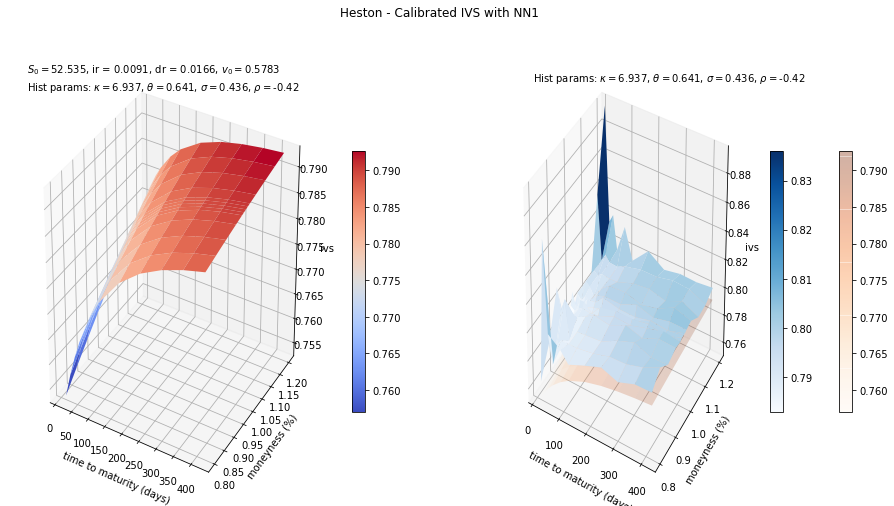

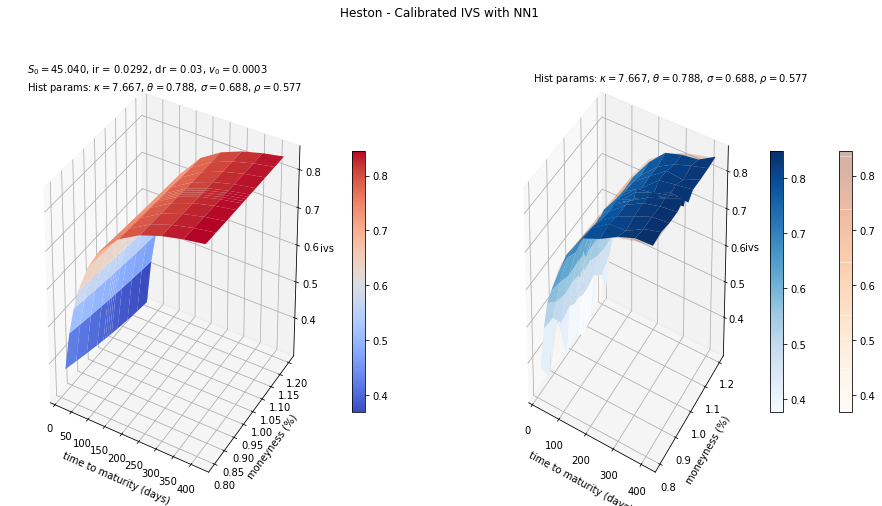

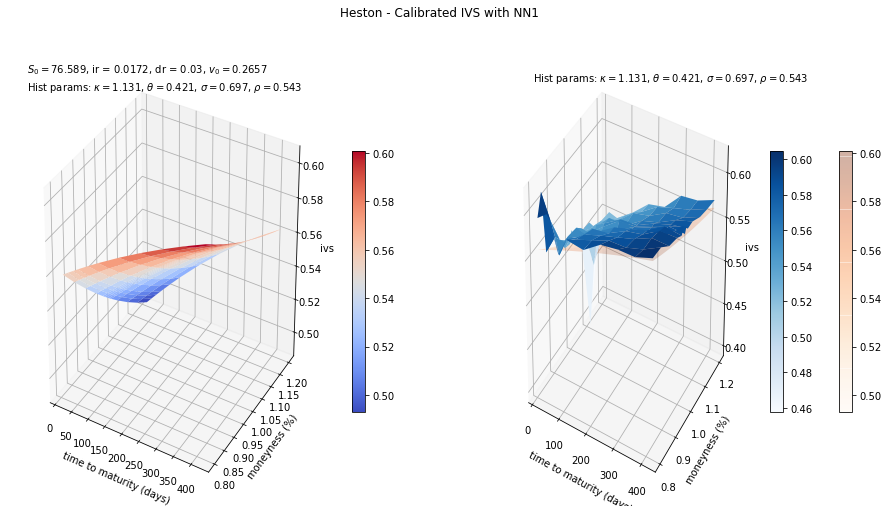

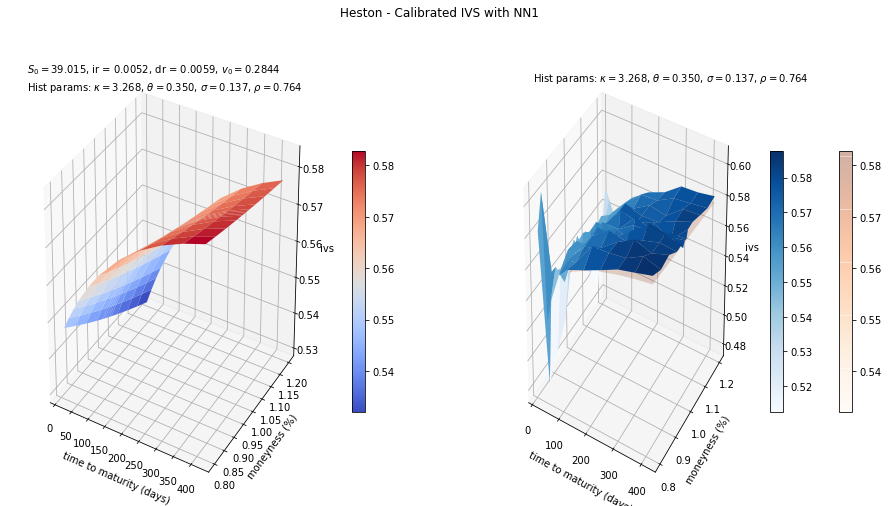

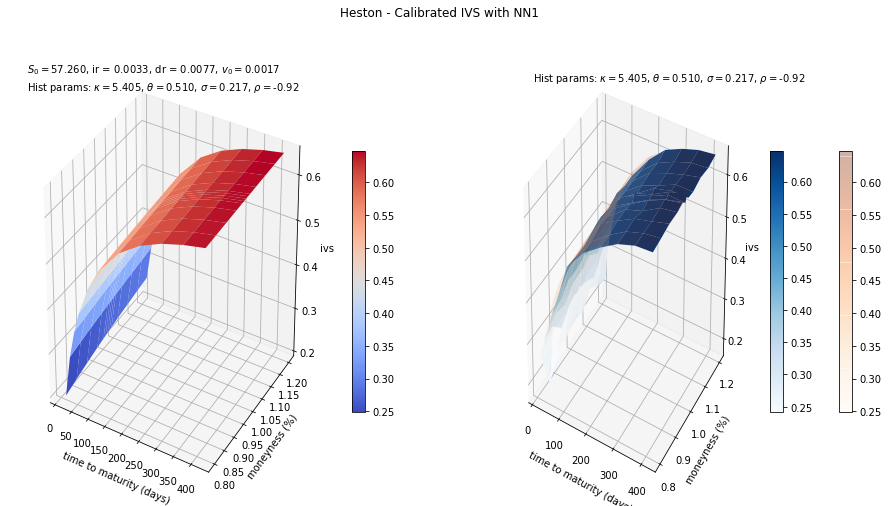

In [10]:
hist_observable = load_dictionary(name_dict='he_observable')
N = len(hist_observable.keys())
for i in range(N):
    fig = nn1_illustration_plot(pred_model1=model, date_index=i)
    fig.savefig('tex/fig/impvolsurf_'+str(i)+'.pdf', transparent=True, dpi=100)

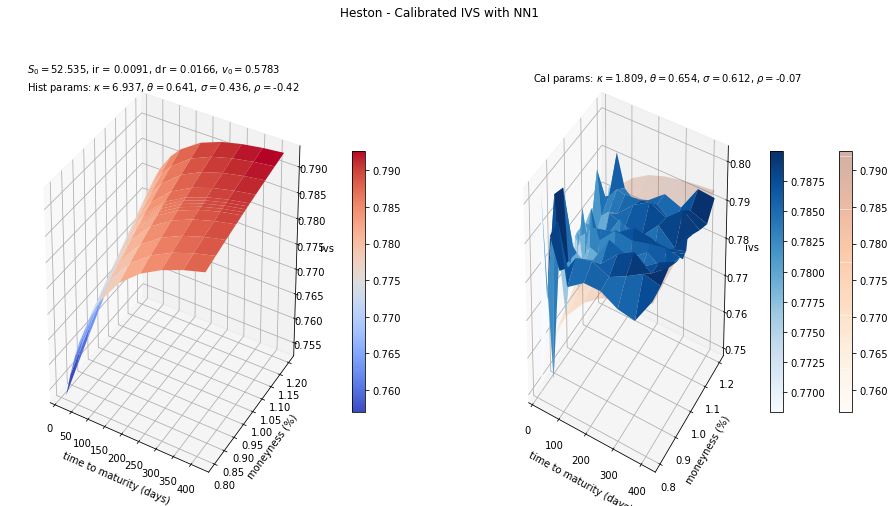

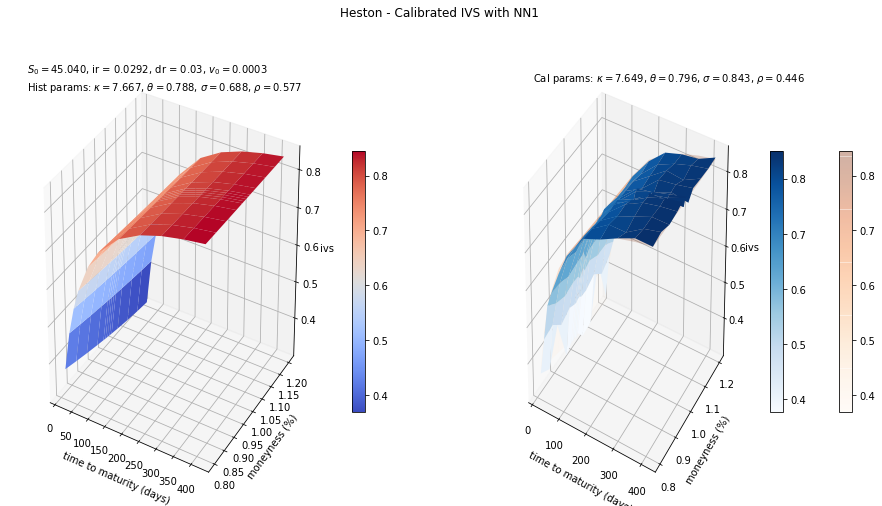

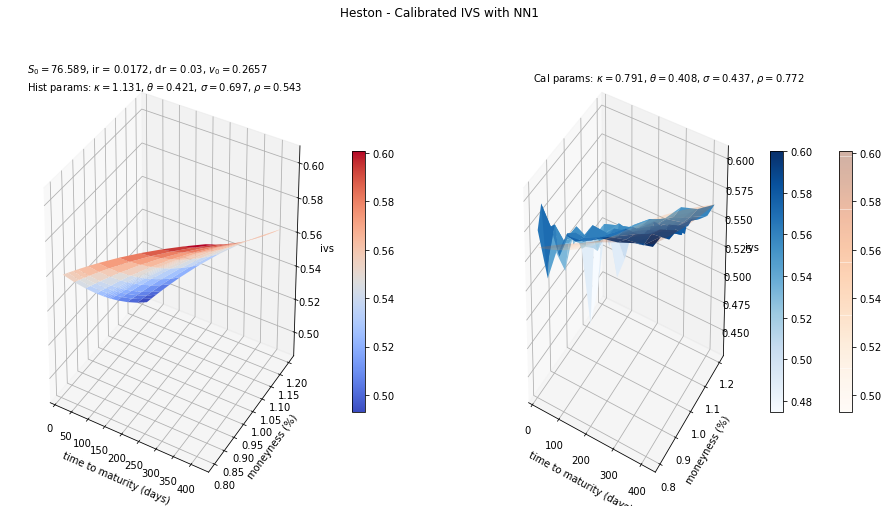

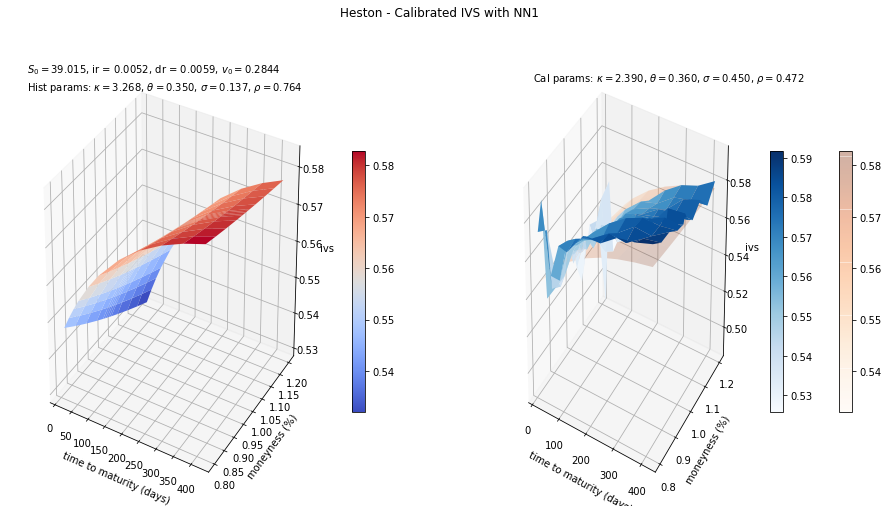

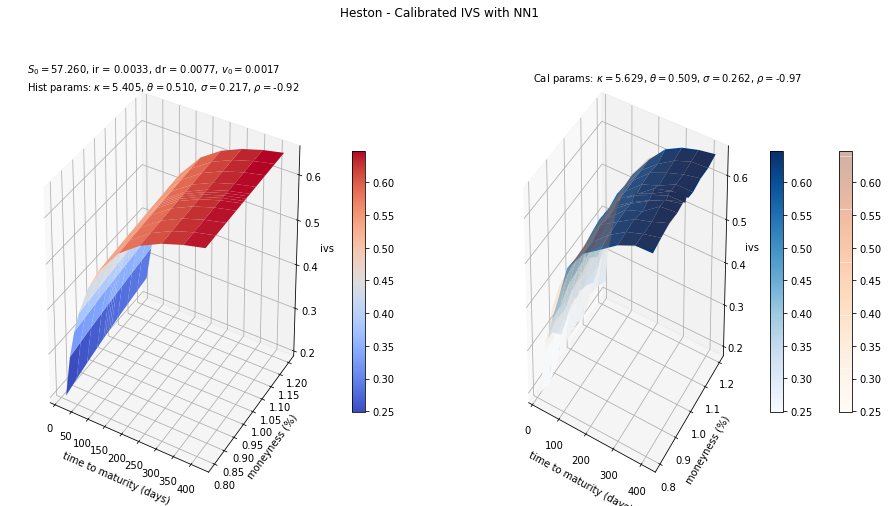

In [11]:
hist_observable = load_dictionary(name_dict='he_observable')
N = len(hist_observable.keys())
for i in range(N):
    fig = nn1_calibration_plot(pred_model1=model, date_index=i)
    fig.savefig('tex/fig/impvolsurf_calibrated_'+str(i)+'.pdf', transparent=True, dpi=100)